In [1]:
#vae.py
import numpy as np

from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.regularizers import l1
from keras.utils import plot_model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# this is the size of our encoded representations
encoding_dim = 3  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
batch_size = 256
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=38,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 2], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 2], x_test_encoded[:, 0], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

In [10]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype('float32')/255.0) - 0.5
x_test = (x_test.astype('float32')/255.0) - 0.5
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
original_dim = x_train.shape[1]
print('x shape', x_train.shape, 'y shape', y_train.shape)
# network parameters
input_shape = (original_dim, )
intermediate_dim = 1024
batch_size = 1000
latent_dim = 16
epochs = 16

x shape (60000, 784) y shape (60000,)


In [11]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         803840      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           16400       dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           16400       dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [13]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
# Compute VAE loss
def vae_loss(y_true, y_pred):
    #reconstruction_loss = original_dim*binary_crossentropy(y_true, y_pred)
    reconstruction_loss = original_dim*mse(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  836640    
_________________________________________________________________
decoder (Model)              (None, 784)               821008    
Total params: 1,657,648
Trainable params: 1,657,648
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  836640    
_________________________________________________________________


(10000,)


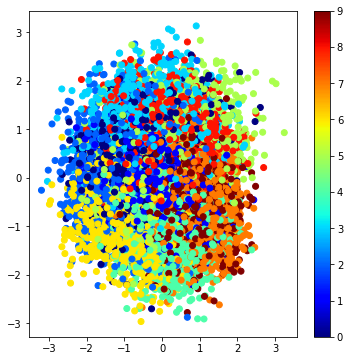

In [14]:
print(y_test.shape)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

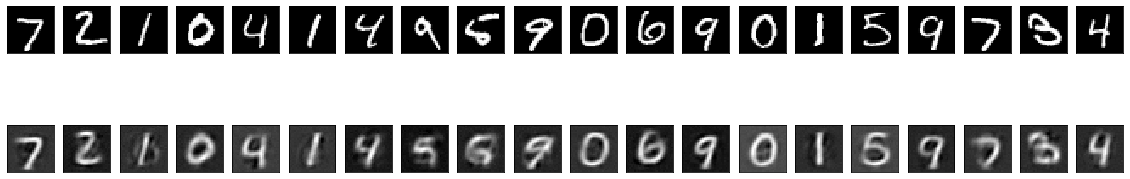

In [15]:
n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
x_test_generated = vae.predict(x_test, batch_size=batch_size)
x_test_generated2 = decoder.predict(x_test_encoded[2])
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_generated[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

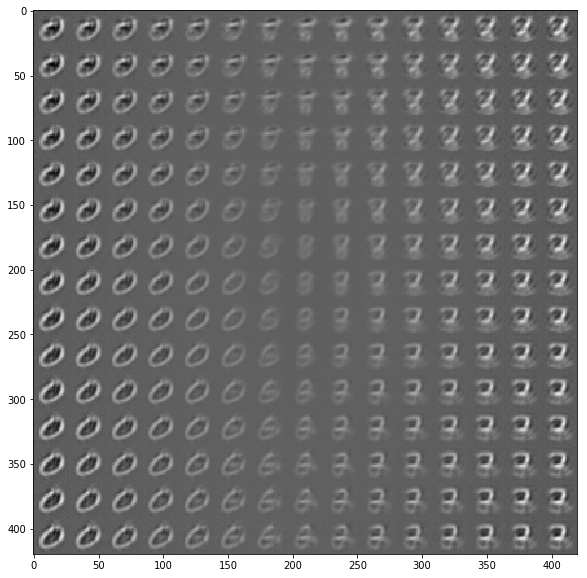

In [24]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)
idx = np.zeros((latent_dim))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        idx[6] = xi
        idx[7] = yi
        z_sample = np.array([idx])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

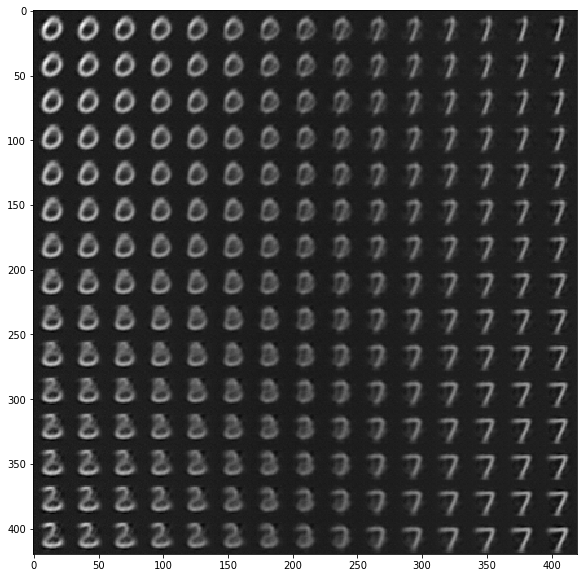

In [19]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)
for i, alpha in enumerate(grid_x):
    for j, alpha2 in enumerate(grid_x):
        z = (alpha*alpha2*x_test_encoded[2][0])
        z += ((1-alpha)*alpha2*x_test_encoded[2][1])
        z += (alpha*(1-alpha2)*x_test_encoded[2][2])
        z += ((1-alpha)*(1-alpha2)*x_test_encoded[2][3])
        z = np.expand_dims(z, axis = 0)
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size, i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()